In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root

In [2]:
cd C:\Users\LIMDAESUN\Desktop\카이스트관련\신용리스크\CDS_Calibrate

C:\Users\LIMDAESUN\Desktop\카이스트관련\신용리스크\CDS_Calibrate


 ## Pricing CDS
 \begin{align}
\ S(0,T) = \frac{\frac{1-R}{2} \sum_{k=1}^{K} [ Z(0,t_{k-1}) + Z(0,t_k)] \bullet 
[Q(0,t_{k-1} ) - Q(0, t_k )]}{RPV01(0,T)} \\
\\
\end{align}
 \begin{align}
\ RPV01(0,T) = \frac{1}{2} \sum_{n=1}^{N} \Delta(t_{n-1} , t_n) Z(0,t_n) [ Q(0,t_{n-1} + Q(0,t_n)] \
\\
\end{align}
#### 　　　　　　　　　　　　　　　　　　　　　　●  k는 1개월 단위(monthly=1/12), 
#### 　　　　　　　　　　　　　　　　　　　　　　● n은 이자기간단위(payment compound) 

## Mark to market value for CDS (CDS long position)
\begin{align}
\ V_{(t)} = \frac{1-R}{2} \sum_{k=1}^{K} [ Z_{(t,t_{k-1})} + Z_{(t,t_k)}] \bullet 
[Q_{(t,t_{k-1} )} - Q_{(t, t_k )}] - S_{previous}\bullet RPV01_{(t,T)}\
\\
\ RPV01_{(t,T)} = \frac{1}{2} \sum_{n=1}^{N} \Delta_{(t_{n-1} , t_n)} Z_{(t,t_n)} [ Q_{(0,t_{n-1}} + Q_{(t,t_n)}]\
\end{align}

In [3]:
CDS_Spread = pd.read_excel('CDS_Spread.xlsx', index_col=0)
Discount = pd.read_excel('Discount.xlsx', index_col=0)

In [25]:
#############Function 1 #####################
def Calculate_CDS_Spread( hazard_rate_array, Discount, dt = 0.5, R = 0.4, Data_result = False) :
    x = np.array(hazard_rate_array)
    DF = pd.concat([pd.DataFrame([ 1], columns = ['Discount']), Discount[['Discount']]], axis = 0)
    surv = pd.DataFrame([1], columns = ['Q'])
    spread_lst = []
    for ii, i in enumerate(np.arange(dt, DF.index[-1]+dt, dt)) :
        T = i
        n = T-dt
        Q_before = surv.Q.loc[n]
        lamb_temp = x[ii]
        timeline = np.linspace(0, dt, int(12 * dt)+1).round(2)[1:]
        Q = np.exp(-lamb_temp * timeline) * Q_before
        surv = pd.concat([surv,pd.DataFrame(Q, index = n+ timeline, columns = ['Q'])], axis = 0)
        Data = pd.concat([DF, surv], axis = 1).interpolate(method = 'linear').loc[:T]
        blue = ((np.array(Data.Discount)[:-1] + np.array(Data.Discount)[1:]) *        
                (np.array(Data.Q)[:-1] - np.array(Data.Q)[1:])).sum()
        Z_ = DF.Discount.loc[0:T]
        Q_ = surv.Q.loc[Z_.index]
        RPV01 = 0.5 * dt * (np.array(Z_.loc[0:T].iloc[1:]) * np.array(Q_.loc[0:T])[:-1] + np.array(Q_.loc[0:T])[1:]).sum()
        spread = 0.5 * (1-R) * blue / (RPV01)
        spread_lst.append(spread)
    if Data_result == False :
        return np.array(spread_lst)
    else : 
        return pd.DataFrame(spread_lst,index = Data.index[int(12 * dt)::int(12 * dt)], columns=['CDS_Spread']).T, Data
    
#############Function 2 #####################
def M_to_M_CDS_long(hazard_rate_array, Discount,S_before_array, dt= 0.5, R = 0.4, Data_result = False) :
    x = np.array(hazard_rate_array)
    S_before_array = np.array(S_before_array).reshape(-1)
    DF = pd.concat([pd.DataFrame([ 1], columns = ['Discount']), Discount[['Discount']]], axis = 0)
    surv = pd.DataFrame([1], columns = ['Q'])
    Value_long_lst = []
    for ii, i in enumerate(np.arange(dt, DF.index[-1]+dt, dt)) :
        T = i
        n = T-dt
        Q_before = surv.Q.loc[n]
        lamb_temp = x[ii]
        timeline = np.linspace(0, dt, int(12 * dt)+1).round(2)[1:]
        Q = np.exp(-lamb_temp * timeline) * Q_before
        surv = pd.concat([surv,pd.DataFrame(Q, index = n+ timeline, columns = ['Q'])], axis = 0)
        Data = pd.concat([DF, surv], axis = 1).interpolate(method = 'linear').loc[:T]
        blue = ((np.array(Data.Discount)[:-1] + np.array(Data.Discount)[1:]) *        
                (np.array(Data.Q)[:-1] - np.array(Data.Q)[1:])).sum()
        Z_ = DF.Discount.loc[0:T]
        Q_ = surv.Q.loc[Z_.index]
        RPV01 = 0.5 * dt * (np.array(Z_.loc[0:T].iloc[1:]) * np.array(Q_.loc[0:T])[:-1] + np.array(Q_.loc[0:T])[1:]).sum()
        V = 0.5 * (1-R) * blue - S_before_array[ii] * RPV01
        Value_long_lst.append(V)
    if Data_result == False :
        return np.array(Value_long_lst)
    else : 
        return pd.DataFrame(Value_long_lst,index = Data.index[int(12 * dt)::int(12 * dt)], columns=['CDS_long_Value']), Data

#############################################    
def CDS_Spread_Interpolate(CDS_Spread,Discount, dt = 0.5) :    
    CDS_Spread_IP = pd.concat([CDS_Spread, pd.DataFrame([], index = np.arange(dt,CDS_Spread.index[-1]+dt,dt))], axis = 1).interpolate(method = 'linear')
    return CDS_Spread_IP

#############Function 3 #####################
def Calibrated_Hazard_Rate(CDS_Spread,Discount,dt,R ) :
    CDS_Spread_IP = np.array(CDS_Spread_Interpolate(CDS_Spread,Discount).Spread)/10000
    def fun(x,Discount, dt, R,P) :
        return  Calculate_CDS_Spread(x,Discount, dt , R) - P
    x0 =np.repeat([0.02],len(CDS_Spread_IP))
    res = root(fun, x0, args = (Discount, dt, R, CDS_Spread_IP))
    return res.x.round(4)

 ### Function1. : Calculating CDS Spread 
 #### ● Input = (hazard_rate_array, Discount, dt, R)
 ##### 　- Hazard Rate Term Structure　 (ex : [0.02, 0.02, 0.02, ....])
 ##### 　- Discount Rate Structure 
 ##### 　- dt is interest payment period
 ##### 　- R is Recovery
  ### Function2. Current CDS M to M Value 
 #### ● Input = (hazard_rate_array, Discount,S_before_array dt, R)
 ##### 　- Hazard Rate Term Structure (ex : [0.02, 0.02, 0.02, ....])
 ##### 　- Discount Rate Structure
 ##### 　- Previous CDS Spread Term Structure (ex : [0.012, 0.013, 0.0125, ....])
 ##### 　- dt is interest payment period
 ##### 　- R is Recovery
  ### Function3. : Calibrating Hazard Rate with Current CDS Spread 
 #### ● Input = (CDS_Spread, Discount, dt, R)
 ##### 　- CDS_Spread is CDS Spread Term Structure　 (ex : [0.015, 0.0164, 0.02, ....])
 ##### 　- Discount Rate Term Structure 
 ##### 　- dt is interest payment period
 ##### 　- R is Recovery

 ### CDS pricing with Hazard Ratio term structure

In [5]:
hr = np.arange(0.02, 0.04,0.001)
CDS_Calculated = Calculate_CDS_Spread( hr, Discount, dt = 0.5, R = 0.4)
CDS_Calculated

array([0.01200028, 0.01226841, 0.01253773, 0.01280505, 0.01307057,
       0.01333361, 0.01359417, 0.0138515 , 0.01410568, 0.01435673,
       0.01460457, 0.01484871, 0.01508915, 0.01532587, 0.01555881,
       0.01578768, 0.01601247, 0.01623315, 0.01644969, 0.01666207])

 ### Calibrate implied hazard rate with Current CDS price

In [6]:
Hazard_Rate = Calibrated_Hazard_Rate(CDS_Spread,Discount,dt= 0.5,R = 0.4) 
Hazard_Rate

array([0.02  , 0.0201, 0.0227, 0.0245, 0.0264, 0.0283, 0.0302, 0.0321,
       0.0341, 0.0361, 0.0225, 0.0216, 0.0208, 0.0199, 0.0314, 0.0322,
       0.0331, 0.0339, 0.0349, 0.0358])

In [7]:
CDS_S, Data = Calculate_CDS_Spread(Hazard_Rate, Discount, dt = 0.5, R = 0.4, Data_result= True)
CDS_S

0.5       1.0       1.5      2.0       2.5    3.0       3.5   \
CDS_Spread  0.012  0.012002  0.012495  0.01299  0.013495  0.014  0.014504   

                4.0       4.5       5.0       5.5       6.0       6.5   \
CDS_Spread  0.015003  0.015504  0.016002  0.015753  0.015502  0.015254   

                7.0       7.5       8.0       8.5      9.0       9.5   \
CDS_Spread  0.015005  0.015172  0.015338  0.015505  0.01567  0.015838   

                10.0  
CDS_Spread  0.016005

In [8]:
np.array(CDS_Spread_Interpolate(CDS_Spread,Discount, dt = 0.5).Spread)

array([120.        , 120.        , 125.        , 130.        ,
       135.        , 140.        , 145.        , 150.        ,
       155.        , 160.        , 157.5       , 155.        ,
       152.5       , 150.        , 151.66666667, 153.33333333,
       155.        , 156.66666667, 158.33333333, 160.        ])

In [9]:
Data.iloc[::12]

Discount         Q
0.0   1.000000  1.000000
1.0   0.983125  0.980150
2.0   0.968850  0.957289
3.0   0.955359  0.931462
4.0   0.941290  0.902894
5.0   0.927618  0.871752
6.0   0.912920  0.852740
7.0   0.898175  0.835563
8.0   0.882524  0.809410
9.0   0.866653  0.782744
10.0  0.850576  0.755557

 ### Calibrated Hazard Rate Term Structure

In [10]:
Hazard_Rate

array([0.02  , 0.0201, 0.0227, 0.0245, 0.0264, 0.0283, 0.0302, 0.0321,
       0.0341, 0.0361, 0.0225, 0.0216, 0.0208, 0.0199, 0.0314, 0.0322,
       0.0331, 0.0339, 0.0349, 0.0358])

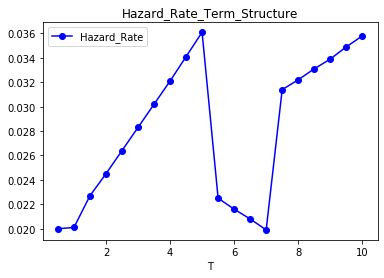

In [14]:
PD = pd.DataFrame(Hazard_Rate, index = CDS_Spread_Interpolate(CDS_Spread,Discount).index, columns = ['Default_Rate'])
plt.plot(PD, label = 'Hazard_Rate', marker = 'o', color = 'blue')
plt.legend(loc = 'best')
plt.xlabel('T')
plt.title('Hazard_Rate_Term_Structure')
plt.show()

 ### Mark to Markte value for CDS (if Hazard Rate paralel increase 1%p )

In [27]:
M_to_M_Value=M_to_M_CDS_long(Hazard_Rate +0.01, Discount,S_before_array = CDS_S, dt= 0.5, R = 0.4, Data_result = True)[0]
M_to_M_Value

CDS_long_Value
0.5         0.002964
1.0         0.005858
1.5         0.008683
2.0         0.011437
2.5         0.014118
3.0         0.016725
3.5         0.019255
4.0         0.021708
4.5         0.024081
5.0         0.026373
5.5         0.028684
6.0         0.030948
6.5         0.033166
7.0         0.035341
7.5         0.037372
8.0         0.039337
8.5         0.041237
9.0         0.043073
9.5         0.044844
10.0        0.046551